In [1]:
##################################   Environment Setup   ########################################

#Import stuff
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Get the plotting functions
import sys
sys.path.append(r"c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions")

# Import custum scripts and functions
from Plots import plot_losses, predict_and_plot, predict_and_quiver, plot_residuals, plot_velocity_profiles, validation_by_flux, print_boundary_summary, predict_and_plot_on_collocation
from Training_Montage import get_unique_run_folder, save_figure, make_video
from The_Reporter import write_report, save_outputs


#Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

########################### Name this script and set up the run folder ###########################
# script_name = "PINN_1_1_Results"
# run_folder = get_unique_run_folder(base_folder="Training Montages", name=script_name)
# figure_folder = get_unique_run_folder(base_folder=run_folder, name="Figures")

Using device: cuda


In [2]:
# ################################## Neural Network Model   #######################################
# layer_size = 60
# activation = nn.Tanh()  

# class PINN(nn.Module):
#     def __init__(self):
#         super(PINN, self).__init__()
#         #define network architecture
#         self.net = nn.Sequential(
#             nn.Linear(2, layer_size),        # 2 inputs (x and y)
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, layer_size),
#             activation,
#             nn.Linear(layer_size, 3)         # 3 outputs (x, y, pressure)
#         )

#     # def normalize_input(self, x):
#     #     # Assumes x is shape [N, 2] with columns [x, y]
#     #     min_x, max_x = 0.0, 1.0      # Set to your domain bounds for x
#     #     min_y, max_y = -0.2, 0.2     # Set to your domain bounds for y
#     #     x_norm = 2 * (x[:, 0:1] - min_x) / (max_x - min_x) - 1
#     #     y_norm = 2 * (x[:, 1:2] - min_y) / (max_y - min_y) - 1
#     #     return torch.cat([x_norm, y_norm], dim=1)

#     #next, define how the input flows through the network.
#     # y will be taken and passed through the layers (self.net)
#     def forward(self, x_y):
#         #x_y = self.normalize_input(x_y)
#         out = self.net(x_y)
#         return out


In [3]:
################################### Neural Network Model   #######################################
layer_size = 60
activation = nn.Tanh()  

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        #define network architecture
        self.shared = nn.Sequential(
            nn.Linear(2, layer_size),        # 2 inputs (x and y)
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            )
        # Velocity branch
        self.velocity_branch = nn.Sequential(
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, 2)  # [u, v]
        )
        # Pressure branch (can be deeper/wider if you want)
        self.pressure_branch = nn.Sequential(
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, 1)  # [p]
        )
        self.apply(xavier_initialization)

    def normalize_input(self, x):
        # Assumes x is shape [N, 2] with columns [x, y]
        min_x, max_x = 0.0, 1.0      # Set to your domain bounds for x
        min_y, max_y = -0.2, 0.2     # Set to your domain bounds for y
        x_norm = 2 * (x[:, 0:1] - min_x) / (max_x - min_x) - 1
        y_norm = 2 * (x[:, 1:2] - min_y) / (max_y - min_y) - 1
        return torch.cat([x_norm, y_norm], dim=1)

    #next, define how the input flows through the network.
    # y will be taken and passed through the layers (self.net)
    def forward(self, x):
        x = self.normalize_input(x)
        features = self.shared(x)
        uv = self.velocity_branch(features)
        p = self.pressure_branch(features)
        return torch.cat([uv, p], dim=1)
    
# Xavier initialization function
def xavier_initialization(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


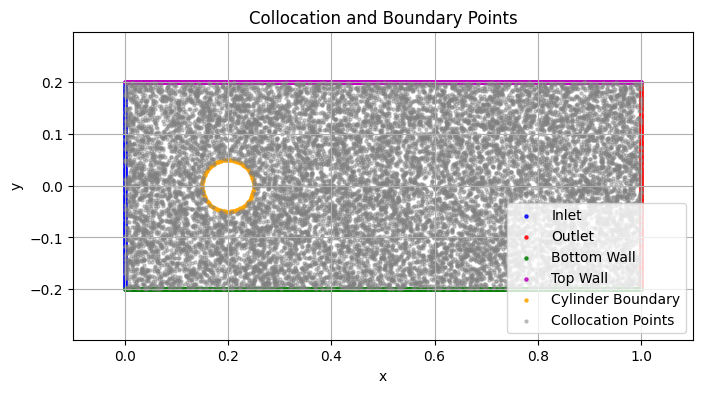

In [4]:
##############################  Boundary Points  ################################################

N_walls = 1000  # numbers of points along each boundary
N_inlet = 200
N_outlet = 200

# Define the nozzle shape parameters
L_total = 1.0  # Total domain length

x_vals_total = np.linspace(0, L_total, N_walls)  # x coordinates across the domain

h_total = np.zeros_like(x_vals_total)  # Initialize height array

# pipe section:
h_total[x_vals_total <= L_total] = 0.2  # Constant height

# Top and bottom walls:
x_y_top = np.stack([x_vals_total, h_total], axis=1)
x_y_bottom = np.stack([x_vals_total, -h_total], axis=1)

# Inlet (x=0):
y_inlet = np.linspace(-h_total[0], h_total[0], N_inlet)
x_y_inlet = np.stack([np.zeros_like(y_inlet), y_inlet], axis=1)

# Outlet (x=L_total):
y_outlet = np.linspace(-h_total[-1], h_total[-1], N_outlet)
x_y_outlet = np.stack([L_total * np.ones_like(y_outlet), y_outlet], axis=1)

# Cylinder boundary points
N_cylinder = 100  # Number of points along the cylinder
cylinder_center = np.array([0.2, 0.0])
cylinder_radius = 0.05  

theta = np.linspace(0, 2 * np.pi, N_cylinder, endpoint=False)
x_cylinder = cylinder_center[0] + cylinder_radius * np.cos(theta)
y_cylinder = cylinder_center[1] + cylinder_radius * np.sin(theta)
x_y_cylinder = np.stack([x_cylinder, y_cylinder], axis=1)

# Convert to torch tensors for training use
x_y_top = torch.tensor(x_y_top, dtype=torch.float32)
x_y_bottom = torch.tensor(x_y_bottom, dtype=torch.float32)
x_y_inlet = torch.tensor(x_y_inlet, dtype=torch.float32)
x_y_outlet = torch.tensor(x_y_outlet, dtype=torch.float32)
x_y_cylinder = torch.tensor(x_y_cylinder, dtype=torch.float32)

################################## Collocation points #########################################

# Generate collocation points inside the ENTIRE domain (including straight sections)
N_collocation = 16384 #98304
x_coll = np.random.uniform(0, L_total, size=(N_collocation, 1))

# Calculate height at each collocation point using the h_total function
h_x = np.interp(x_coll.flatten(), x_vals_total, h_total)  # Use interpolation

# Ensure y_coll is strictly within the domain
margin = 0 #1e-3
y_coll = np.random.uniform(-h_x + margin, h_x - margin)
y_coll = y_coll.reshape(x_coll.shape) # Reshape to match x_coll dimensions

x_y_collocation = np.hstack([x_coll, y_coll])
x_y_collocation = torch.tensor(x_y_collocation, dtype=torch.float32, requires_grad=True)

# Filter out points that are inside the cylinder
coll_np = x_y_collocation.detach().cpu().numpy()
dist_to_center = np.sqrt((coll_np[:, 0] - cylinder_center[0])**2 + (coll_np[:, 1] - cylinder_center[1])**2)
mask = dist_to_center > cylinder_radius  # True if outside cylinder
x_y_collocation = torch.tensor(coll_np[mask], dtype=torch.float32, requires_grad=True)


######################## Plot collocation and boundary points   #################################
plt.figure(figsize=(8, 4))

# Plot boundary points
plt.scatter(x_y_inlet[:, 0], x_y_inlet[:, 1], s=5, c='b', label='Inlet', alpha=0.8)
plt.scatter(x_y_outlet[:, 0], x_y_outlet[:, 1], s=5, c='r', label='Outlet', alpha=0.8)
plt.scatter(x_y_bottom[:, 0], x_y_bottom[:, 1], s=5, c='g', label='Bottom Wall', alpha=0.8)
plt.scatter(x_y_top[:, 0], x_y_top[:, 1], s=5, c='m', label='Top Wall', alpha=0.8)
plt.scatter(x_y_cylinder[:, 0], x_y_cylinder[:, 1], s=5, c='orange', label='Cylinder Boundary', alpha=0.8)

# Plot collocation points
x_coll_np = x_y_collocation.detach().numpy()
plt.scatter(x_coll_np[:, 0], x_coll_np[:, 1], s=5, c='gray', label='Collocation Points', alpha=0.4)

plt.title("Collocation and Boundary Points")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.xlim(-0.1,1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.legend()
plt.show()

In [5]:
################ Boundary condition definition  ##############################

#Inlet - a PARABOLA
U_max = 1.0
h0 = h_total[0]  # Height at the inlet (y=0)
u_inlet = U_max * (1 - (x_y_inlet[:, 1] / h0)**2).unsqueeze(1)  # make the inlet velocity a parabola (U_max at centre and 0 at sides)
#u_inlet = torch.full_like(x_y_inlet[:, 1].unsqueeze(1), U_max)  # inlet velocity is a constant
v_inlet = torch.zeros_like(u_inlet)   # velocity in y is zero for the input
p_inlet = torch.zeros_like(u_inlet)  # optional, can be ignored or fixed to 0

target_inlet = torch.cat([u_inlet, v_inlet, p_inlet], dim=1).to(device)

# Outlet, pressure outlet
# Just set the pressure to zero

# Walls, all velocities zero
def compute_normals(coords):
    dx = torch.gradient(coords[:, 0])[0] # change in x
    dy = torch.gradient(coords[:, 1])[0] # change in y
    tangents = torch.stack([dx, dy], dim=1) # get tangent
    normals = torch.stack([-tangents[:, 1], tangents[:, 0]], dim=1)  # Rotate tangents 90° to get the normals
    normals = torch.nn.functional.normalize(normals, dim=1)  #normalize to unit length
    return normals

def decompose_wall_velocity(pred, normals):
        tangents = torch.stack([normals[:, 1], -normals[:, 0]], dim=1)  # Rotate normal -90°
        u = pred[:, 0:1]
        v = pred[:, 1:2]
        u_n = u * normals[:, 0:1] + v * normals[:, 1:2]        # normal velocity
        u_t = u * tangents[:, 0:1] + v * tangents[:, 1:2]      # tangential velocity
        return u_n, u_t

##**The loss functions**

Here the physics and the boundary loss are defined. Then, inside the train_pinn loop they are combined into the total loss.

In [6]:
#################################### Physics loss  ########################################################
def physics_loss(model, x_y, Re):
    x_y.requires_grad_(True)
    out = model(x_y)    #predict the velocities
    u = out[:, 0:1]     #get the velocity in x
    v = out[:, 1:2]     #get the velocity in y
    p = out[:, 2:3]     #get the pressure

    # Compute gradients
    grads = lambda f, wrt: torch.autograd.grad(f, wrt, grad_outputs=torch.ones_like(f), create_graph=True)[0]

    du_dx = grads(u, x_y)[:, 0:1]
    du_dy = grads(u, x_y)[:, 1:2]
    dv_dx = grads(v, x_y)[:, 0:1]
    dv_dy = grads(v, x_y)[:, 1:2]
    dp_dx = grads(p, x_y)[:, 0:1]
    dp_dy = grads(p, x_y)[:, 1:2]

    d2u_dx2 = grads(du_dx, x_y)[:, 0:1]
    d2u_dy2 = grads(du_dy, x_y)[:, 1:2]
    d2v_dx2 = grads(dv_dx, x_y)[:, 0:1]
    d2v_dy2 = grads(dv_dy, x_y)[:, 1:2]

    # Residuals of Navier-Stokes
    momentum_x = - 1 / Re * (d2u_dx2 + d2u_dy2) + u * du_dx + v * du_dy + dp_dx
    momentum_y = - 1 / Re * (d2v_dx2 + d2v_dy2) + u * dv_dx + v * dv_dy + dp_dy
    #momentum_x = - mu * (d2u_dx2 + d2u_dy2) + u * du_dx + v * du_dy - dp_dx
    #momentum_y = - mu * (d2v_dx2 + d2v_dy2) + u * dv_dx + v * dv_dy - dp_dy
    continuity = du_dx + dv_dy

    # Return the mean of the residuals
    loss_momentum_x = torch.mean(momentum_x**2)
    loss_momentum_y = torch.mean(momentum_y**2)
    loss_continuity = torch.mean(continuity**2)
    
    # Return the l2 norm of the residuals
    #loss_momentum_x = torch.norm(momentum_x, p=2) / momentum_x.shape[0]
    #loss_momentum_y = torch.norm(momentum_y, p=2) / momentum_y.shape[0]
    #loss_continuity = torch.norm(continuity, p=2) / continuity.shape[0]
    
    return loss_momentum_x, loss_momentum_y, loss_continuity

########################################## Boundary loss  ################################################
def boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder, target_inlet):
    # Predict
    pred_inlet = model(x_y_inlet)
    pred_outlet = model(x_y_outlet)
    pred_top = model(x_y_top)
    pred_bottom = model(x_y_bottom)
    pred_cylinder = model(x_y_cylinder) 
    normals_top = compute_normals(x_y_top).to(device)
    normals_bottom = compute_normals(x_y_bottom).to(device)
    normals_cylinder = compute_normals(x_y_cylinder).to(device)

    # Inlet: match u, v (no p)
    # inlet MSE loss
    inlet_loss = torch.mean((pred_inlet[:, 0:1] - target_inlet[:, 0:1])**2) + \
                 torch.mean((pred_inlet[:, 1:2] - target_inlet[:, 1:2])**2)

    # # Inlet loss: l2 norm
    # inlet_x = pred_inlet[:, 0:1] - target_inlet[:, 0:1]
    # inlet_y = pred_inlet[:, 1:2] - target_inlet[:, 1:2]
    # inlet_loss = torch.norm(inlet_x, p=2) / inlet_x.shape[0] + torch.norm(inlet_y, p=2) / inlet_y.shape[0]

    # Outlet:
    outlet_loss = torch.mean(pred_outlet[:, 2:3]**2) ## MSE
    # outlet = pred_outlet[:, 2:3]
    # outlet_loss = torch.norm(outlet, p=2) / outlet.shape[0] ## l2 norm

    # Walls: no-slip
    # decompose into normal and tangential
    u_n_top, u_t_top = decompose_wall_velocity(pred_top, normals_top)
    u_n_bot, u_t_bot = decompose_wall_velocity(pred_bottom, normals_bottom)
    u_n_cyl, u_t_cyl = decompose_wall_velocity(pred_cylinder, normals_cylinder)

    # MSE loss for walls
    wall_loss = torch.mean(u_n_top**2) + torch.mean(u_t_top**2) \
                + torch.mean(u_n_bot**2) + torch.mean(u_t_bot**2) \
                + torch.mean(u_n_cyl**2) + torch.mean(u_t_cyl**2)   
    
    # l2 norm loss for walls
    # wall_loss = torch.norm(u_n_top, p=2)  / u_n_top.shape[0] \
    #             + torch.norm(u_t_top, p=2)/ u_t_top.shape[0] \
    #             + torch.norm(u_n_bot, p=2)/ u_n_bot.shape[0] \
    #             + torch.norm(u_t_bot, p=2)/ u_t_bot.shape[0] \
    #             + torch.norm(u_n_cyl, p=2)/ u_n_cyl.shape[0] \
    #             + torch.norm(u_t_cyl, p=2)/ u_t_cyl.shape[0] 

    return inlet_loss, wall_loss, outlet_loss

##**The network training loop and a prediction**

In [7]:
# # Single

# # Move to GPU
# x_y_collocation = x_y_collocation.to(device)
# x_y_top = x_y_top.to(device)
# x_y_bottom = x_y_bottom.to(device)
# x_y_inlet = x_y_inlet.to(device)
# x_y_outlet = x_y_outlet.to(device)
# x_y_cylinder = x_y_cylinder.to(device)

# epoch_start = 0
# epoch_end = 20000
# epoch_end = epoch_end + 1 # +1 to include the last epoch in the training

# lr_drop_epoch = 3000
# gamma= 0.5
# initial_lr = 0.001

# lambda_x_mom = 1.0
# lambda_y_mom = 1.0
# lambda_cont = 1.0
# lambda_inlet = 1.0
# lambda_wall = 1.0
# lambda_outlet = 1.0

# sections = [
#         ("Pipe", 0.0, L_total)
#     ]

# #################################  Training Loop  #########################################

# def train_pinn(model, x_y_collocation, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder, Re,
#                       epoch_start=epoch_start, epoch_end = epoch_end, lr_drop_epoch=lr_drop_epoch, gamma=gamma,
#                       initial_lr=initial_lr,
#                       lambda_x_mom=lambda_x_mom, lambda_y_mom=lambda_y_mom,
#                       lambda_cont=lambda_cont, lambda_inlet=lambda_inlet,
#                       lambda_wall=lambda_wall, lambda_outlet=lambda_outlet):

#     optimizer = optim.Adam([
#         {'params': model.shared.parameters(), 'lr': initial_lr},           # Shared layers
#         {'params': model.velocity_branch.parameters(), 'lr': initial_lr},  # Velocity branch
#         {'params': model.pressure_branch.parameters(), 'lr': 0.001}  # Pressure branch 
#     ]
#     #, betas=(0.89, 0.98)
#     )

#     # optimizer = optim.Adam(model.parameters(), lr=0.0001
#     #                        #, betas=(0.89, 0.98)
#     #                        )
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_epoch, gamma=gamma)

#     x_y_collocation.requires_grad_(True)

#     loss_history = []
#     physics_loss_history = []
#     boundary_loss_history = []
#     loss_phys_x_history = []
#     loss_phys_y_history = []    
#     loss_continuity_history = []
#     loss_bc_inlet_history = []
#     loss_bc_wall_history = []
#     loss_bc_outlet_history = []

#     for epoch in range(epoch_start,epoch_end):

#         optimizer.zero_grad()

#         loss_phys_x, loss_phys_y, loss_continuity = physics_loss(model, x_y_collocation, Re)
#         loss_bc_inlet, loss_bc_wall, loss_bc_outlet = boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder,
#                     target_inlet)
        
#         loss_phys_x = loss_phys_x * lambda_x_mom
#         loss_phys_y = loss_phys_y * lambda_y_mom
#         loss_continuity = loss_continuity * lambda_cont
#         loss_bc_inlet = loss_bc_inlet * lambda_inlet
#         loss_bc_wall = loss_bc_wall * lambda_wall
#         loss_bc_outlet = loss_bc_outlet * lambda_outlet

#         loss_phys = loss_phys_x + loss_phys_y
#         loss_phys.backward(retain_graph=True)

#         loss_velocity = loss_bc_inlet + loss_bc_wall + loss_continuity
#         velocity_params = list(model.shared.parameters()) + list(model.velocity_branch.parameters())
#         loss_velocity.backward(retain_graph=True, inputs=velocity_params)

#         pressure_params = list(model.shared.parameters()) + list(model.pressure_branch.parameters())
#         loss_bc_outlet.backward(inputs=pressure_params)

#         # Combine all losses for plotting
#         loss_bc = loss_bc_inlet + loss_bc_wall + loss_bc_outlet
#         total_loss = loss_phys + loss_bc 


#         #total_loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#         optimizer.step()
#         scheduler.step()

#         # Log
#         loss_history.append(total_loss.item())
#         physics_loss_history.append(loss_phys.item())
#         boundary_loss_history.append(loss_bc.item())
#         loss_phys_x_history.append(loss_phys_x.item())
#         loss_phys_y_history.append(loss_phys_y.item())
#         loss_continuity_history.append(loss_continuity.item())
#         loss_bc_inlet_history.append(loss_bc_inlet.item())
#         loss_bc_wall_history.append(loss_bc_wall.item())
#         loss_bc_outlet_history.append(loss_bc_outlet.item())

#         if epoch % 100 == 0:
#             fig1, fig2 = predict_and_plot(model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=1.5, min_pres=-1, max_pres=1)
#             save_figure(fig1, epoch, prefix="velocity", folder=figure_folder)
#             save_figure(fig2, epoch, prefix="pressure", folder=figure_folder)

#             if epoch % 1000 == 0:
#                 print(f"Epoch {epoch} | Total Loss: {total_loss.item():.4e} | Phys: {loss_phys.item():.4e} | BC: {loss_bc.item():.4e}")

#             if epoch % 1000 == 0:
#                 #plt.show(fig1)
#                 torch.save({
#                             'epoch': epoch,
#                             'model_state_dict': model.state_dict(),
#                             'optimizer_state_dict': optimizer.state_dict(),
#                             'loss': total_loss
#                         }, 'trained_pinn_nozzle.pth')   # save the model for later re-loading
                
#             plt.close(fig1)
#             plt.close(fig2)
            
#     make_video(input_folder=figure_folder, output_folder=run_folder, output="velocity_montage.mp4", fps=10, prefix="velocity")
#     make_video(input_folder=figure_folder, output_folder=run_folder, output="pressure_montage.mp4", fps=10, prefix="pressure")

#     return model, loss_history, physics_loss_history, boundary_loss_history, optimizer, \
#                     loss_phys_x_history, loss_phys_y_history, loss_continuity_history, loss_bc_inlet_history, loss_bc_wall_history, loss_bc_outlet_history

# #########################   Run the training and plot the plots  ##########################

# ##### Values for non-dimensionalization #####
# L_ref = L_total # Reference length for non-dimensionalization
# D_ref = 2*h0  # Reference diameter for non-dimensionalization
# U_ref = U_max  # Reference velocity for non-dimensionalization
# U_mean = (2/3) * U_ref  # Mean velocity for the pipe flow, assuming parabolic profile
# rho = 1.0  # Density of water for non-dimensionalization [kg/m^3]
# mu = 0.02   # Dynamic viscosity of water for non-dimensionalization [Pa*s]
# nu = mu / rho  # Kinematic viscosity
# A = np.pi * (D_ref / 2)**2  # Cross-sectional area of the pipe
# Re_inlet =  U_mean *  D_ref / nu  # Reynolds number at the inlet
# Q = U_mean * A  # Volumetric flow rate
# Re_nozzle = rho * Q * D_ref / (mu * A)  # Reynolds number for the nozzle part
# Re = 5

# model = PINN().to(device)
# trained_model, loss_history, physics_loss_history, boundary_loss_history,  optimizer, \
#     loss_phys_x_history, loss_phys_y_history, loss_continuity_history, loss_bc_inlet_history, loss_bc_wall_history, loss_bc_outlet_history = train_pinn(
#     model,
#     x_y_collocation,
#     x_y_inlet,
#     x_y_outlet,
#     x_y_top,
#     x_y_bottom,
#     x_y_cylinder,
#     Re=Re,
#     epoch_start=epoch_start,
#     epoch_end=epoch_end,
#     lr_drop_epoch=lr_drop_epoch)

# final_epoch = epoch_end - 1  # Last epoch index
# final_loss = loss_history[-1]  # Last loss value

# torch.save({
#     'epoch': final_epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_velocity_state_dict': optimizer.state_dict(),
#     'loss': final_loss
# }, 'trained_pinn_nozzle.pth')   # save the model to train longer later

# # plot_losses("Total Loss",
# #                     **{
# #                         "Total Loss": loss_history
# #                     })

# # plot_losses("Physics Loss",
# #                     **{ 
# #                         "Physics Loss": physics_loss_history,
# #                         "Boundary Loss": boundary_loss_history,
# #                     })

In [ ]:
# Batch
 
# Move to GPU
x_y_collocation = x_y_collocation.to(device)
x_y_top = x_y_top.to(device)
x_y_bottom = x_y_bottom.to(device)
x_y_inlet = x_y_inlet.to(device)
x_y_outlet = x_y_outlet.to(device)
x_y_cylinder = x_y_cylinder.to(device)

epoch_start = 0
epoch_end = 30000
epoch_end = epoch_end + 1 # +1 to include the last epoch in the training

lr_drop_epoch = 5000
gamma= 0.5
initial_lr = 0.001

lambda_x_mom = 1.0
lambda_y_mom = 2.0
lambda_cont = 1.0
lambda_inlet = 1.0
lambda_wall = 2.0
lambda_outlet = 3.0

batch_size = 16384

sections = [
        ("Pipe", 0.0, L_total)
    ]

#################################  Training Loop  #########################################

def train_pinn(model, x_y_collocation, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder, Re,
                      epoch_start=epoch_start, epoch_end = epoch_end, lr_drop_epoch=lr_drop_epoch, gamma=gamma,
                      initial_lr=initial_lr,
                      lambda_x_mom=lambda_x_mom, lambda_y_mom=lambda_y_mom,
                      lambda_cont=lambda_cont, lambda_inlet=lambda_inlet,
                      lambda_wall=lambda_wall, lambda_outlet=lambda_outlet, batch_size=batch_size):

    optimizer = optim.Adam([
        {'params': model.shared.parameters(), 'lr': initial_lr},           # Shared layers
        {'params': model.velocity_branch.parameters(), 'lr': initial_lr},  # Velocity branch
        {'params': model.pressure_branch.parameters(), 'lr': 0.0005}  # Pressure branch 
    ], betas=(0.89, 0.98))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_epoch, gamma=gamma)

    num_collocation_points = x_y_collocation.shape[0]

    loss_history = []
    physics_loss_history = []
    boundary_loss_history = []
    loss_phys_x_history = []
    loss_phys_y_history = []    
    loss_continuity_history = []
    loss_bc_inlet_history = []
    loss_bc_wall_history = []
    loss_bc_outlet_history = []

    for epoch in range(epoch_start,epoch_end):
        # Shuffle collocation points at the start of each epoch (only the collocation points get batches, the boundary points are fixed)
        perm = torch.randperm(num_collocation_points)
        x_y_collocation_shuffled = x_y_collocation[perm]

        # Initialize accumulators for batch losses
        total_loss_epoch = 0.0
        loss_phys_epoch = 0.0
        loss_bc_epoch = 0.0
        loss_phys_x_epoch = 0.0
        loss_phys_y_epoch = 0.0
        loss_continuity_epoch = 0.0
        loss_bc_inlet_epoch = 0.0
        loss_bc_wall_epoch = 0.0
        loss_bc_outlet_epoch = 0.0
        num_batches = 0

        for batch_start in range(0, num_collocation_points, batch_size):
            batch_end = min(batch_start + batch_size, num_collocation_points)
            x_y_collocation_batch = x_y_collocation_shuffled[batch_start:batch_end].clone().detach().requires_grad_(True)

            optimizer.zero_grad()

            loss_phys_x, loss_phys_y, loss_continuity = physics_loss(model, x_y_collocation_batch, Re)
            loss_bc_inlet, loss_bc_wall, loss_bc_outlet = boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder,
                    target_inlet)
            
            loss_phys_x = loss_phys_x * lambda_x_mom
            loss_phys_y = loss_phys_y * lambda_y_mom
            loss_continuity = loss_continuity * lambda_cont
            loss_bc_inlet = loss_bc_inlet * lambda_inlet
            loss_bc_wall = loss_bc_wall * lambda_wall
            loss_bc_outlet = loss_bc_outlet * lambda_outlet

            loss_phys = loss_phys_x + loss_phys_y
            loss_phys.backward(retain_graph=True)

            loss_velocity = loss_bc_inlet + loss_bc_wall + loss_continuity
            velocity_params = list(model.shared.parameters()) + list(model.velocity_branch.parameters())
            loss_velocity.backward(retain_graph=True, inputs=velocity_params)

            pressure_params = list(model.shared.parameters()) + list(model.pressure_branch.parameters())
            loss_bc_outlet.backward(inputs=pressure_params)

            # Combine all losses for plotting
            loss_bc = loss_bc_inlet + loss_bc_wall + loss_bc_outlet
            total_loss = loss_phys + loss_bc 

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Accumulate batch losses
            total_loss_epoch += total_loss.item()
            loss_phys_epoch += loss_phys.item()
            loss_bc_epoch += loss_bc.item()
            loss_phys_x_epoch += loss_phys_x.item()
            loss_phys_y_epoch += loss_phys_y.item()
            loss_continuity_epoch += loss_continuity.item()
            loss_bc_inlet_epoch += loss_bc_inlet.item()
            loss_bc_wall_epoch += loss_bc_wall.item()
            loss_bc_outlet_epoch += loss_bc_outlet.item()
            num_batches += 1
            
        scheduler.step()

        # Average losses over all batches in this epoch
        loss_history.append(total_loss_epoch / num_batches)
        physics_loss_history.append(loss_phys_epoch / num_batches)
        boundary_loss_history.append(loss_bc_epoch / num_batches)
        loss_phys_x_history.append(loss_phys_x_epoch / num_batches)
        loss_phys_y_history.append(loss_phys_y_epoch / num_batches)
        loss_continuity_history.append(loss_continuity_epoch / num_batches)
        loss_bc_inlet_history.append(loss_bc_inlet_epoch / num_batches)
        loss_bc_wall_history.append(loss_bc_wall_epoch / num_batches)
        loss_bc_outlet_history.append(loss_bc_outlet_epoch / num_batches)

        if epoch % 100 == 0:
            fig1, fig2 = predict_and_plot(model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=1.5, min_pres=-1, max_pres=1)
            save_figure(fig1, epoch, prefix="velocity", folder=figure_folder)
            save_figure(fig2, epoch, prefix="pressure", folder=figure_folder)

            if epoch % 1000 == 0:
                print(f"Epoch {epoch} | Total Loss: {total_loss_epoch/num_batches:.4e} | Phys: {loss_phys_epoch/num_batches:.4e} | BC: {loss_bc_epoch/num_batches:.4e}")

            if epoch % 1000 == 0:
                #plt.show(fig1)
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'scheduler_state_dict': scheduler.state_dict(),
                            'loss': total_loss_epoch / num_batches
                        }, 'trained_pinn_cyl.pth')   # save the model for later re-loading
                
            plt.close(fig1)
            plt.close(fig2)

    make_video(input_folder=figure_folder, output_folder=run_folder, output="velocity_montage.mp4", fps=10, prefix="velocity")
    make_video(input_folder=figure_folder, output_folder=run_folder, output="pressure_montage.mp4", fps=10, prefix="pressure")

    return model, loss_history, physics_loss_history, boundary_loss_history, optimizer, \
                    loss_phys_x_history, loss_phys_y_history, loss_continuity_history, loss_bc_inlet_history, loss_bc_wall_history, loss_bc_outlet_history

#########################   Run the training and plot the plots  ##########################

##### Values for non-dimensionalization #####
L_ref = L_total # Reference length for non-dimensionalization
D_ref = 2 * h0  # Reference diameter for non-dimensionalization
U_ref = U_max # Reference velocity for non-dimensionalization
U_mean = (2/3) * U_ref  # Mean velocity for the pipe flow, assuming parabolic profile
rho = 1000.0  # Density of water for non-dimensionalization
mu = 0.001   # Dynamic viscosity of water for non-dimensionalization
nu = mu / rho  # Kinematic viscosity
Re =  U_mean *  D_ref / nu  # Reynolds number at the inlet
Re = 5

# model = PINN().to(device)
# trained_model, loss_history, physics_loss_history, boundary_loss_history,  optimizer, \
#     loss_phys_x_history, loss_phys_y_history, loss_continuity_history, loss_bc_inlet_history, loss_bc_wall_history, loss_bc_outlet_history = train_pinn(
#     model,
#     x_y_collocation,
#     x_y_inlet,
#     x_y_outlet,
#     x_y_top,
#     x_y_bottom,
#     x_y_cylinder,
#     Re=Re,
#     epoch_start=epoch_start,
#     epoch_end=epoch_end,
#     lr_drop_epoch=lr_drop_epoch)

# final_epoch = epoch_end - 1  # Last epoch index
# final_loss = loss_history[-1]  # Last loss value

# torch.save({
#     'epoch': final_epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
#     'loss': final_loss
# }, 'trained_pinn_nozzle.pth')  # save the model to train longer later

# plot_losses("Total Loss",
#                     **{
#                         "Total Loss": loss_history
#                     })

# plot_losses("Physics Loss",
#                     **{ 
#                         "Physics Loss": physics_loss_history,
#                         "Boundary Loss": boundary_loss_history,
#                     })

In [ ]:
#create a report folder and write the report
report_folder = write_report(
    filename=script_name,

    ####
    N_collocation=N_collocation,
    epoch_start=epoch_start,
    epoch_end=epoch_end,
    problem_description="2D flow around a cylinder in a channel.",

    # Network
    layer_number=None,  
    layer_size=layer_size,
    activation=activation,
    network_notes="Branched network. Hidden layers 3 shared + 7/9 in each branch (velocity/pressure). Velocity branch has 2 relu 5 tanh activations, " \
    "the relu in the middle, pressure all tanh. Input normalization and normalized momentum loss, Xavier initialization.",
    
    # Domain
    N_walls=N_walls,
    N_inlet=N_inlet,
    N_outlet=N_outlet,
    L_total=L_total,
    H_ref=h0 if 'h0' in locals() else h_total[0],
    domain_notes=f"Cylinder info: center at x={0.2}, y=0, radius={0.05}, number of boundary wall points=100. batches over collocation points, num_batch 16384",
    
    # Boundary conditions and loss
    inlet_type="Velocity inlet",
    U_max=U_max,
    U_profile="Parabolic velocity profile: U_max * (1 - (y/h0)^2)",
    wall_type="No-slip",
    outlet_type="Pressure outlet",
    mu=mu,
    rho=rho,
    Re=Re if 'Re' in locals() else Re_inlet,
    BC_Loss_notes="Loss branched, inlet, walls, and continuity to velocity, outlet to pressure, momentum to all. Loss  MSE.",

    # Training
    Optimizer="Adam",
    initial_lr=initial_lr,
    lr_drop_epoch=lr_drop_epoch,
    gamma=gamma,
    lambda_x_mom=lambda_x_mom,
    lambda_y_mom=lambda_y_mom,
    lambda_cont=lambda_cont,
    lambda_wall=lambda_wall,
    lambda_outlet=lambda_outlet,
    lambda_inlet=lambda_inlet,
    Training_notes="Scheduler: StepLR, gradient clipping. Velocity and common branches same initial learning rate, pressure is 0.0005, betas=(0.89, 0.98). ",
)

Report written to PINN_1_1_Results
Report written to c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Reports\PINN_1_1_Results_22\PINN_1_1_Results


In [ ]:
# save outputs
save_outputs(
    report_folder,
    [
        # Loss plots
        {
            'func': plot_losses,
            'args': ("Total Loss",),
            'kwargs': {"Total Loss": loss_history},
            'filename': "total_loss",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Physics and Boundary Losses",),
            'kwargs': {
                "Physics Loss": physics_loss_history,
                "Boundary Loss": boundary_loss_history
            },
            'filename': "physics_boundary_losses",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Physics-Based Losses",),
            'kwargs': {
                "X-Momentum (Physics)": loss_phys_x_history,
                "Y-Momentum (Physics)": loss_phys_y_history,
                "Continuity (Mass)": loss_continuity_history
            },
            'filename': "physics_losses",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Boundary Condition Losses",),
            'kwargs': {
                "Inlet BC": loss_bc_inlet_history,
                "Wall BC": loss_bc_wall_history,
                "Outlet BC": loss_bc_outlet_history
            },
            'filename': "boundary_losses",
            'type': 'plot'
        },
        # Prediction plots
        {
            'func': predict_and_plot,
            'args': (trained_model, device, sections, x_vals_total, h_total, 0, 1.5, -1, 1),
            'filename': "predict_and_plot",
            'type': 'plot'
        },
        {
            'func': predict_and_quiver,
            'args': (trained_model, device, sections),
            'kwargs': {
                "x_vals_total": x_vals_total,
                "h_total": h_total,
                "density": 300,
                "scale": 10,
                "ymin": -0.6,
                "ymax": 0.6,
                "y_density": 500
            },
            'filename': "predict_and_quiver",
            'type': 'plot'
        },
        {
            'func': plot_residuals,
            'args': (trained_model, device, 0.001, (0, 1), (-0.2, 0.2), 200, 100),
            'kwargs': {
                "x_y_inlet": x_y_inlet,
                "x_y_outlet": x_y_outlet,
                "x_y_top": x_y_top,
                "x_y_bottom": x_y_bottom
            },
            'filename': "residuals",
            'type': 'plot'
        },
        {
            'func': plot_velocity_profiles,
            'args': (trained_model, device, x_vals_total, h_total, L_total, x_y_inlet, x_y_outlet, [0.25, 0.5, 0.75, 1.0]),
            'kwargs': {"scale": 1},
            'filename': "velocity_profiles",
            'type': 'plot'
        },
        # Text outputs
        {
            'func': validation_by_flux,
            'args': (trained_model, x_vals_total, h_total, L_total),
            'filename': "flux_info.txt",
            'type': 'text'
        },
        {
            'func': print_boundary_summary,
            'args': (trained_model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom),
            'filename': "boundary_summary.txt",
            'type': 'text'
        },
        {
            'func': predict_and_plot_on_collocation,
            'args': (trained_model, device, x_y_collocation, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder,
                                    x_vals_total, h_total, 0.0, 1.5, -1, 1),
            'filename': "predict_and_plot_collocation",
            'type': 'plot'
        }
    ]
)

In [ ]:
crash crash crash

##**Continue training**

If more epochs are needed, train some more

In [ ]:
########################  Train Longer!   ###################################################

#### Load the pre-trained model 
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('trained_pinn_nozzle.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
epoch_start = checkpoint['epoch'] + 1  # Continue from last epoch
loss = checkpoint['loss']

epoch_end = epoch_start + 10000  # Train for X more epochs

# Continue training
trained_model, new_loss_history, new_physics_loss_history, new_boundary_loss_history, optimizer, \
    new_loss_phys_x_history, new_loss_phys_y_history, new_loss_continuity_history, \
    new_loss_bc_inlet_history, new_loss_bc_wall_history, new_loss_bc_outlet_history = train_pinn(
    model,
    x_y_collocation,
    x_y_inlet,
    x_y_outlet,
    x_y_top,
    x_y_bottom,
    x_y_cylinder,
    Re=Re,
    epoch_start=epoch_start,
    epoch_end=epoch_end,
    lr_drop_epoch=lr_drop_epoch)

# If you have previous histories, extend them. Otherwise, just use the new ones.
try:
    loss_history.extend(new_loss_history)
    physics_loss_history.extend(new_physics_loss_history)
    boundary_loss_history.extend(new_boundary_loss_history)
except NameError:
    loss_history = new_loss_history
    physics_loss_history = new_physics_loss_history
    boundary_loss_history = new_boundary_loss_history

torch.save({'epoch': epoch_end - 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history[-1]},
            'trained_pinn_cyl.pth')   # save the model for later re-loading

In [8]:
########################  Train Longer with L-BFGS!   ###################################################
learning_rate = [0.1, 0.01]

for learningrate in learning_rate:

    Re = 5

    # Move to GPU
    x_y_collocation = x_y_collocation.to(device)
    x_y_top = x_y_top.to(device)
    x_y_bottom = x_y_bottom.to(device)
    x_y_inlet = x_y_inlet.to(device)
    x_y_outlet = x_y_outlet.to(device)
    x_y_cylinder = x_y_cylinder.to(device)


    lambda_x_mom = 1.0
    lambda_y_mom = 2.0
    lambda_cont = 1.0
    lambda_inlet = 1.0
    lambda_wall = 2.0
    lambda_outlet = 3.0

    sections = [
            ("Pipe", 0.0, L_total)
        ]
    #### Load the pre-trained model 
    model = PINN().to(device)
    checkpoint = torch.load('trained_pinn_nozzle.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch_start = checkpoint['epoch'] + 1  # Continue from last epoch
    loss = checkpoint['loss']

    epoch_end = epoch_start + 1001  # Train for X more epochs



    new_loss_history = []
    new_physics_loss_history = []
    new_boundary_loss_history = []
    new_loss_phys_x_history = []
    new_loss_phys_y_history = []
    new_loss_continuity_history = []
    new_loss_bc_inlet_history = []
    new_loss_bc_wall_history = []
    new_loss_bc_outlet_history = []

    model.train()

    closure_calls = 0

    def closure():
        global closure_calls
        closure_calls += 1
        optimizer.zero_grad()

        loss_phys_x, loss_phys_y, loss_continuity = physics_loss(model, x_y_collocation, Re)
        loss_bc_inlet, loss_bc_wall, loss_bc_outlet = boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder,
                target_inlet)
        
        loss_phys_x = loss_phys_x * lambda_x_mom
        loss_phys_y = loss_phys_y * lambda_y_mom
        loss_continuity = loss_continuity * lambda_cont
        loss_bc_inlet = loss_bc_inlet * lambda_inlet
        loss_bc_wall = loss_bc_wall * lambda_wall
        loss_bc_outlet = loss_bc_outlet * lambda_outlet

        loss_phys = loss_phys_x + loss_phys_y + loss_continuity
        loss_bc = loss_bc_inlet + loss_bc_wall + loss_bc_outlet
        
        total_loss = loss_phys + loss_bc 

        total_loss.backward()
        return total_loss


    script_name = "PINN_1_1_Results_LBFGS_lr_" + str(learningrate)
    run_folder = get_unique_run_folder(base_folder="Training Montages", name=script_name)
    figure_folder = get_unique_run_folder(base_folder=run_folder, name="Figures")
    
    for epoch in range(epoch_start, epoch_end):
        

        optimizer = torch.optim.LBFGS(
                    model.parameters(),
                    lr=learningrate,                    
                    max_iter=100,             
                    max_eval=None,             
                    history_size=100,          
                    #line_search_fn='strong_wolfe',  
                    tolerance_grad=1e-4,
                    tolerance_change=1e-9 
                )
        #print(f"Epoch {epoch} - Starting L-BFGS step")
        prev_params = torch.cat([p.detach().clone().flatten() for p in model.parameters()])

        #print("Before step: ", list(model.parameters())[0][0,0].item())
        closure_calls = 0   

        optimizer.step(closure)

        loss_phys_x, loss_phys_y, loss_continuity = physics_loss(model, x_y_collocation, Re)
        loss_bc_inlet, loss_bc_wall, loss_bc_outlet = boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder, target_inlet)

        loss_phys_x = loss_phys_x * lambda_x_mom
        loss_phys_y = loss_phys_y * lambda_y_mom
        loss_continuity = loss_continuity * lambda_cont
        loss_bc_inlet = loss_bc_inlet * lambda_inlet
        loss_bc_wall = loss_bc_wall * lambda_wall
        loss_bc_outlet = loss_bc_outlet * lambda_outlet

        loss_phys = loss_phys_x + loss_phys_y + loss_continuity
        loss_bc = loss_bc_inlet + loss_bc_wall + loss_bc_outlet
        total_loss = loss_phys + loss_bc

        # Store logs
        new_loss_history.append(total_loss.item())
        new_physics_loss_history.append(loss_phys.item())
        new_boundary_loss_history.append(loss_bc.item())
        new_loss_phys_x_history.append(loss_phys_x.item())
        new_loss_phys_y_history.append(loss_phys_y.item())
        new_loss_continuity_history.append(loss_continuity.item())
        new_loss_bc_inlet_history.append(loss_bc_inlet.item())
        new_loss_bc_wall_history.append(loss_bc_wall.item())
        new_loss_bc_outlet_history.append(loss_bc_outlet.item())

        new_params = torch.cat([p.detach().clone().flatten() for p in model.parameters()])
        #print(torch.norm(prev_params - new_params))  # Should not be 0

        param_delta = torch.norm(prev_params - new_params)
        

        # total_grad = torch.sqrt(sum((p.grad.data.norm(2) ** 2 for p in model.parameters() if p.grad is not None)))
        # print(f"Gradient norm: {total_grad:.3e}")

        # print("After step: ", list(model.parameters())[0][0,0].item())
        # print("Closure calls:", closure_calls)

        # for name, param in model.named_parameters():
        #     if not param.requires_grad:
        #         print(f"{name} is frozen!")


        if epoch % 10 == 0:  # print every x epochs
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
            grad_norm = total_norm ** 0.5

            loss_total = new_loss_history[-1]
            loss_phys_x = new_loss_phys_x_history[-1]
            loss_phys_y = new_loss_phys_y_history[-1]
            loss_continuity = new_loss_continuity_history[-1]
            loss_bc_inlet = new_loss_bc_inlet_history[-1]
            loss_bc_wall = new_loss_bc_wall_history[-1]
            loss_bc_outlet = new_loss_bc_outlet_history[-1]

            print(f"Epoch {epoch} Gradient norm: {grad_norm:.2e}, Param delta: {param_delta:.3e}")
            # print(f"Total Loss: {loss_total:.4e}")
            # print(f"    Loss phys_x: {loss_phys_x:.4e}, phys_y: {loss_phys_y:.4e}, continuity: {loss_continuity:.4e}")
            # print(f"    Loss bc_inlet: {loss_bc_inlet:.4e}, bc_wall: {loss_bc_wall:.4e}, bc_outlet: {loss_bc_outlet:.4e}")

            fig1, fig2 = predict_and_plot(model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=1.5, min_pres=-1, max_pres=1)
            save_figure(fig1, epoch, prefix="velocity", folder=figure_folder)
            save_figure(fig2, epoch, prefix="pressure", folder=figure_folder)

            if epoch % 100 == 0:
                torch.save({'epoch': epoch_end - 1,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': new_loss_history[-1]},
                            'trained_pinn_cyl_lbfgs_lr_' + str(learningrate) + '.pth')  
                    
            plt.close(fig1)
            plt.close(fig2)

    make_video(input_folder=figure_folder, output_folder=run_folder, output="velocity_montage.mp4", fps=10, prefix="velocity")
    make_video(input_folder=figure_folder, output_folder=run_folder, output="pressure_montage.mp4", fps=10, prefix="pressure")

    # save outputs
    save_outputs(run_folder,
    [
        # Loss plots
        {
            'func': plot_losses,
            'args': ("Total Loss",),
            'kwargs': {"Total Loss": new_loss_history},
            'filename': "total_loss",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Physics and Boundary Losses",),
            'kwargs': {
                "Physics Loss": new_physics_loss_history,
                "Boundary Loss": new_boundary_loss_history
            },
            'filename': "physics_boundary_losses",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Physics-Based Losses",),
            'kwargs': {
                "X-Momentum (Physics)": new_loss_phys_x_history,
                "Y-Momentum (Physics)": new_loss_phys_y_history,
                "Continuity (Mass)": new_loss_continuity_history
            },
            'filename': "physics_losses",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Boundary Condition Losses",),
            'kwargs': {
                "Inlet BC": new_loss_bc_inlet_history,
                "Wall BC": new_loss_bc_wall_history,
                "Outlet BC": new_loss_bc_outlet_history
            },
            'filename': "boundary_losses",
            'type': 'plot'
        },
        # Prediction plots
        {
            'func': predict_and_plot,
            'args': (model, device, sections, x_vals_total, h_total, 0, 1.5, -1, 1),
            'filename': "predict_and_plot",
            'type': 'plot'
        },
        {
            'func': predict_and_quiver,
            'args': (model, device, sections),
            'kwargs': {
                "x_vals_total": x_vals_total,
                "h_total": h_total,
                "density": 300,
                "scale": 10,
                "ymin": -0.6,
                "ymax": 0.6,
                "y_density": 500
            },
            'filename': "predict_and_quiver",
            'type': 'plot'
        },
        {
            'func': plot_residuals,
            'args': (model, device, 0.001, (0, 1), (-0.2, 0.2), 200, 100),
            'kwargs': {
                "x_y_inlet": x_y_inlet,
                "x_y_outlet": x_y_outlet,
                "x_y_top": x_y_top,
                "x_y_bottom": x_y_bottom
            },
            'filename': "residuals",
            'type': 'plot'
        },
        {
            'func': plot_velocity_profiles,
            'args': (model, device, x_vals_total, h_total, L_total, x_y_inlet, x_y_outlet, [0.25, 0.5, 0.75, 1.0]),
            'kwargs': {"scale": 1},
            'filename': "velocity_profiles",
            'type': 'plot'
        },
        # Text outputs
        {
            'func': validation_by_flux,
            'args': (model, x_vals_total, h_total, L_total),
            'filename': "flux_info.txt",
            'type': 'text'
        },
        {
            'func': print_boundary_summary,
            'args': (model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom),
            'filename': "boundary_summary.txt",
            'type': 'text'
        },
        {
            'func': predict_and_plot_on_collocation,
            'args': (model, device, x_y_collocation, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder,
                                    x_vals_total, h_total, 0.0, 1.5, -1, 1),
            'filename': "predict_and_plot_collocation",
            'type': 'plot'
        }
    ]
    )


# try:
#     loss_history.extend(new_loss_history)
#     physics_loss_history.extend(new_physics_loss_history)
#     boundary_loss_history.extend(new_boundary_loss_history)
#     loss_phys_x_history.extend(new_loss_phys_x_history)
#     loss_phys_y_history.extend(new_loss_phys_y_history)
#     loss_continuity_history.extend(new_loss_continuity_history)
#     loss_bc_inlet_history.extend(new_loss_bc_inlet_history)
#     loss_bc_wall_history.extend(new_loss_bc_wall_history)
#     loss_bc_outlet_history.extend(new_loss_bc_outlet_history)
# except NameError:
#     loss_history = new_loss_history
#     physics_loss_history = new_physics_loss_history
#     boundary_loss_history = new_boundary_loss_history
#     loss_phys_x_history = new_loss_phys_x_history
#     loss_phys_y_history = new_loss_phys_y_history
#     loss_continuity_history = new_loss_continuity_history
#     loss_bc_inlet_history = new_loss_bc_inlet_history
#     loss_bc_wall_history = new_loss_bc_wall_history
#     loss_bc_outlet_history = new_loss_bc_outlet_history

# torch.save({'epoch': epoch_end - 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_history[-1]},
#             'trained_pinn_cyl_lbfgs.pth')   # save the model for later re-loading

C:\Users\nv1n24\AppData\Local\Temp\ipykernel_38472\157870684.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('trained_pinn_nozzle.pth')


Epoch 30010 Gradient norm: 5.88e-02, Param delta: 7.615e-04


c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions\Plots.py:109: UserWarning: Adding colorbar to a different Figure <Figure size 500x200 with 2 Axes> than <Figure size 500x200 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(all_contours_v[0], ax=ax1, label="Velocity Magnitude [m/s]")


Epoch 30020 Gradient norm: 3.59e-02, Param delta: 8.705e-04
Epoch 30030 Gradient norm: 4.46e-02, Param delta: 7.488e-04
Epoch 30040 Gradient norm: 1.98e-02, Param delta: 1.623e-03
Epoch 30050 Gradient norm: 3.13e-02, Param delta: 1.630e-03
Epoch 30060 Gradient norm: 4.20e-02, Param delta: 1.282e-03
Epoch 30070 Gradient norm: 2.90e-02, Param delta: 3.026e-03
Epoch 30080 Gradient norm: 7.46e-02, Param delta: 1.288e-03
Epoch 30090 Gradient norm: 4.18e-02, Param delta: 1.195e-03
Epoch 30100 Gradient norm: 6.23e-02, Param delta: 1.165e-02
Epoch 30110 Gradient norm: 5.91e-02, Param delta: 8.276e-04
Epoch 30120 Gradient norm: 3.86e-02, Param delta: 1.549e-04
Epoch 30130 Gradient norm: 3.12e-02, Param delta: 4.068e-04
Epoch 30140 Gradient norm: 2.44e-02, Param delta: 6.735e-04
Epoch 30150 Gradient norm: 3.35e-02, Param delta: 1.714e-03
Epoch 30160 Gradient norm: 6.47e-03, Param delta: 4.752e-05
Epoch 30170 Gradient norm: 3.82e-02, Param delta: 2.395e-03
Epoch 30180 Gradient norm: 2.61e-02, Par

C:\Users\nv1n24\AppData\Local\Temp\ipykernel_38472\157870684.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('trained_pinn_nozzle.pth')


Epoch 30010 Gradient norm: 2.02e-01, Param delta: 1.029e-04
Epoch 30020 Gradient norm: 1.91e-01, Param delta: 9.749e-05


KeyboardInterrupt: 

In [13]:
trained_model = model = PINN().to(device)
checkpoint = torch.load('trained_pinn_cyl_lbfgs_lr_0.5.pth')
model.load_state_dict(checkpoint['model_state_dict'])
report_folder = run_folder

# save outputs
save_outputs(
    report_folder,
    [
        # Loss plots
        {
            'func': plot_losses,
            'args': ("Total Loss",),
            'kwargs': {"Total Loss": new_loss_history},
            'filename': "total_loss",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Physics and Boundary Losses",),
            'kwargs': {
                "Physics Loss": new_physics_loss_history,
                "Boundary Loss": new_boundary_loss_history
            },
            'filename': "physics_boundary_losses",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Physics-Based Losses",),
            'kwargs': {
                "X-Momentum (Physics)": new_loss_phys_x_history,
                "Y-Momentum (Physics)": new_loss_phys_y_history,
                "Continuity (Mass)": new_loss_continuity_history
            },
            'filename': "physics_losses",
            'type': 'plot'
        },
        {
            'func': plot_losses,
            'args': ("Boundary Condition Losses",),
            'kwargs': {
                "Inlet BC": new_loss_bc_inlet_history,
                "Wall BC": new_loss_bc_wall_history,
                "Outlet BC": new_loss_bc_outlet_history
            },
            'filename': "boundary_losses",
            'type': 'plot'
        },
        # Prediction plots
        {
            'func': predict_and_plot,
            'args': (trained_model, device, sections, x_vals_total, h_total, 0, 1.5, -1, 1),
            'filename': "predict_and_plot",
            'type': 'plot'
        },
        {
            'func': predict_and_quiver,
            'args': (trained_model, device, sections),
            'kwargs': {
                "x_vals_total": x_vals_total,
                "h_total": h_total,
                "density": 300,
                "scale": 10,
                "ymin": -0.6,
                "ymax": 0.6,
                "y_density": 500
            },
            'filename': "predict_and_quiver",
            'type': 'plot'
        },
        {
            'func': plot_residuals,
            'args': (trained_model, device, 0.001, (0, 1), (-0.2, 0.2), 200, 100),
            'kwargs': {
                "x_y_inlet": x_y_inlet,
                "x_y_outlet": x_y_outlet,
                "x_y_top": x_y_top,
                "x_y_bottom": x_y_bottom
            },
            'filename': "residuals",
            'type': 'plot'
        },
        {
            'func': plot_velocity_profiles,
            'args': (trained_model, device, x_vals_total, h_total, L_total, x_y_inlet, x_y_outlet, [0.25, 0.5, 0.75, 1.0]),
            'kwargs': {"scale": 1},
            'filename': "velocity_profiles",
            'type': 'plot'
        },
        # Text outputs
        {
            'func': validation_by_flux,
            'args': (trained_model, x_vals_total, h_total, L_total),
            'filename': "flux_info.txt",
            'type': 'text'
        },
        {
            'func': print_boundary_summary,
            'args': (trained_model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom),
            'filename': "boundary_summary.txt",
            'type': 'text'
        },
        {
            'func': predict_and_plot_on_collocation,
            'args': (trained_model, device, x_y_collocation, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, x_y_cylinder,
                                    x_vals_total, h_total, 0.0, 1.5, -1, 1),
            'filename': "predict_and_plot_collocation",
            'type': 'plot'
        }
    ]
)

C:\Users\nv1n24\AppData\Local\Temp\ipykernel_17088\510151479.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('trained_pinn_cyl_lbfgs_lr_0.5.pth')

c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions\Plots.py:109: UserWarning: Adding colorbar to a different Figure <Figure size 500x200 with 2 Axes> than <Figure size 500x200 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(all_contours_v[0], ax=ax1, label="Velocity Magnitude [m/s]")


Volumetric flow rate at inlet:  0.265056
Volumetric flow rate at outlet: 0.262971
Relative difference: 0.79%


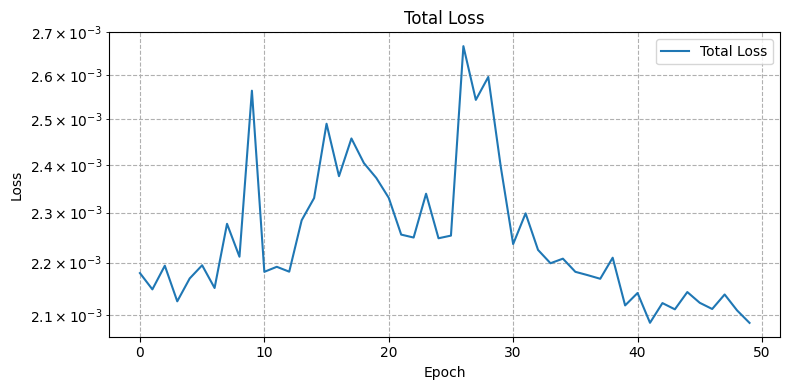

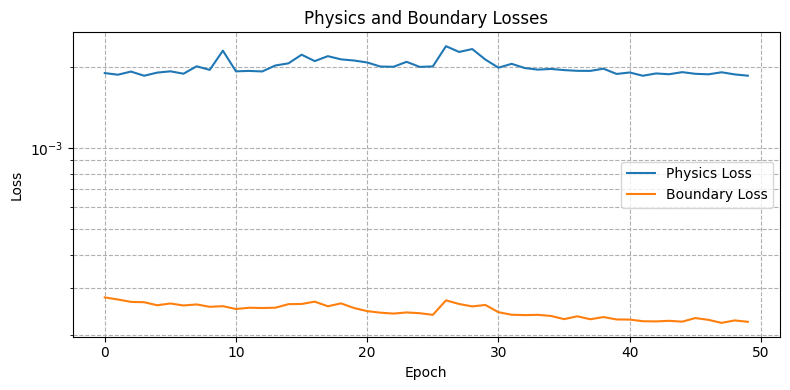

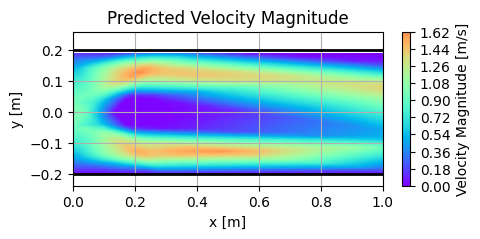

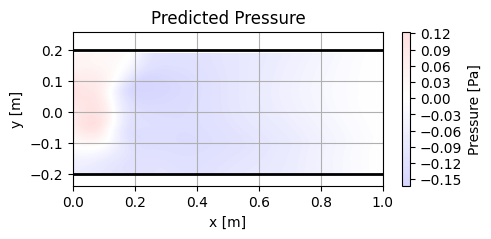

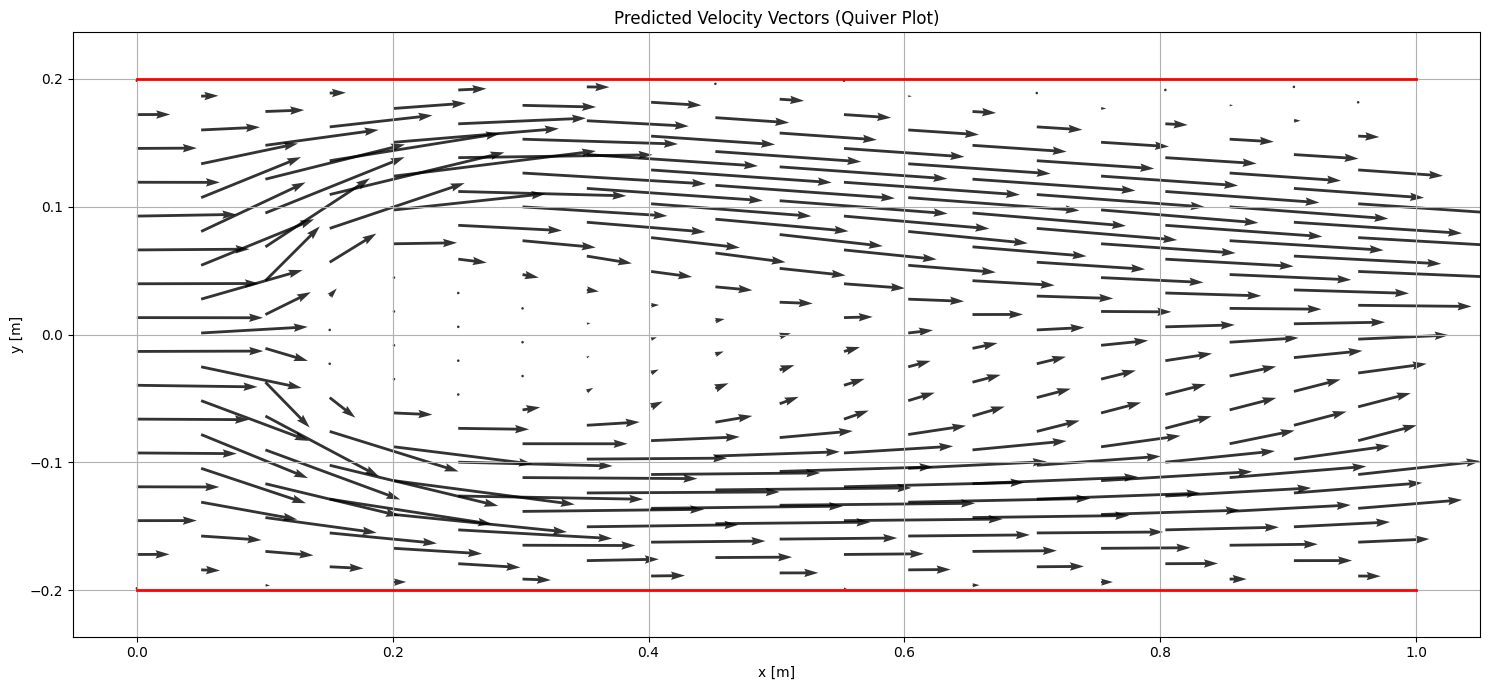

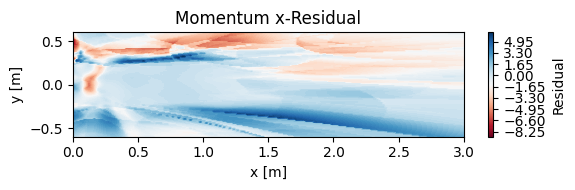

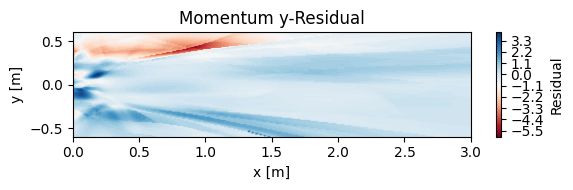

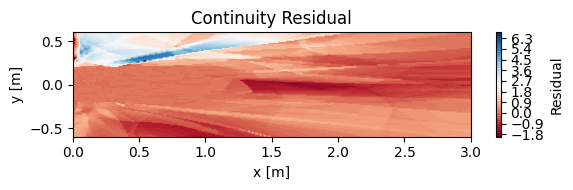

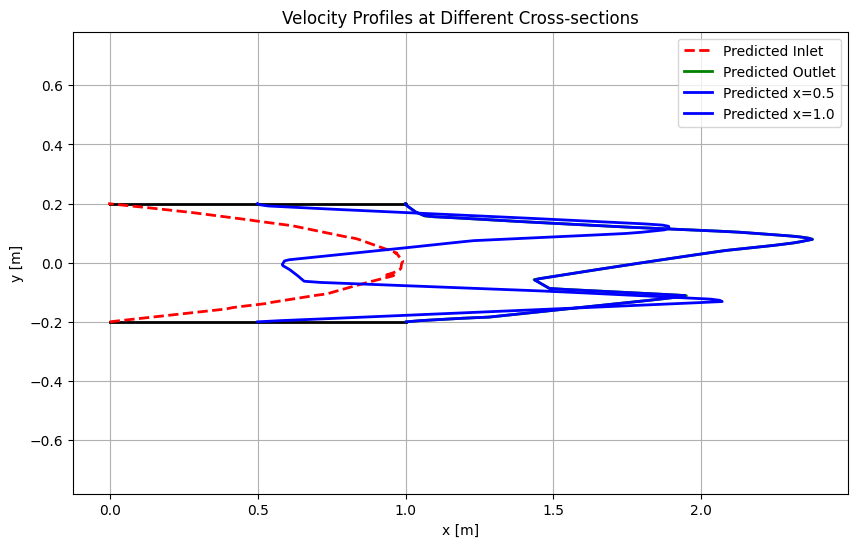

In [9]:
plot_losses("Total Loss",
                    **{
                        "Total Loss": loss_history
                    })

plot_losses("Physics and Boundary Losses",
                    **{
                        "Physics Loss": physics_loss_history,
                        "Boundary Loss": boundary_loss_history
                    })


# # First plot: Physics-related losses
# plot_losses(
#     "Physics-Based Losses",
#     **{
#         "X-Momentum (Physics)": loss_phys_x_history,
#         "Y-Momentum (Physics)": loss_phys_y_history,
#         "Continuity (Mass)": loss_continuity_history
#     }
# )

# # Second plot: Boundary condition losses
# plot_losses(
#     "Boundary Condition Losses",
#     **{
#         "Inlet BC": loss_bc_inlet_history,
#         "Wall BC": loss_bc_wall_history,
#         "Outlet BC": loss_bc_outlet_history
#     }
# )

fig1, fig2 = predict_and_plot(model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=2, min_pres=-1, max_pres=1)

fig_quiver = predict_and_quiver(model, device, sections, x_vals_total=x_vals_total,
                                h_total=h_total, density=300, scale=10, xlim=None, ylim=None, ymin=-0.6, ymax=0.6, y_density=500)

plot_residuals(model, device, mu=0.2, x_range= (0,3), y_range = (-0.6, 0.6), x_points = 200, y_points = 100,
                     x_y_inlet=x_y_inlet, x_y_outlet=x_y_outlet, x_y_top=x_y_top, x_y_bottom=x_y_bottom)

x_locs= [0.5, 1.0]

plot_velocity_profiles(model, device, x_vals_total=x_vals_total, h_total=h_total, L_total=L_total, x_y_inlet=x_y_inlet,
                       x_y_outlet=x_y_outlet, x_locs=x_locs, scale=1)

validation_by_flux(model, x_vals_total, h_total, L_total)
